In [5]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

from Visualise import Visualise

## Select Dates to Show

In [6]:
# date picker to choose a start date
widg_start = widgets.DatePicker(
                    description='Start Date:',
                    value=pd.datetime.now(),
                    disabled=False
                )

# date picker to choose an end date
widg_end = widgets.DatePicker(
                    description='End Date:',
                    value=pd.datetime.now()+pd.Timedelta('365 days'),
                    disabled=False
                )

freq_dict = {'Monthly':'MS','Weekly':'W-MON','Daily':'D'}

# radio buttons to choose the frequency of dates to display in tables/heatmaps
widg_freq = widgets.RadioButtons(
    options=freq_dict.keys(),
    description='Frequency:',
    disabled=False
)

display(widg_start, widg_end, widg_freq)

DatePicker(value=datetime.datetime(2019, 4, 11, 16, 7, 51, 861939), description='Start Date:')

DatePicker(value=datetime.datetime(2020, 4, 10, 16, 7, 51, 869135), description='End Date:')

RadioButtons(description='Frequency:', options=('Monthly', 'Weekly', 'Daily'), value='Monthly')

## Load Data

In [7]:
vis = Visualise(start_date=pd.to_datetime(widg_start.value), 
                end_date=pd.to_datetime(widg_end.value), 
                freq=freq_dict[widg_freq.value],
                init_harvest=False)

In [8]:
def update_vis_params(change):
    vis.START_DATE = pd.to_datetime(widg_start.value)
    vis.END_DATE = pd.to_datetime(widg_end.value)
    vis.FREQ = freq_dict[widg_freq.value]

widg_start.observe(update_vis_params, names='value')
widg_end.observe(update_vis_params, names='value')
widg_freq.observe(update_vis_params, names='value')

## Rough Equivalents of Martin's Spreadsheet

In [9]:
vis.styled_sheet('person')

In [10]:
vis.styled_sheet('project')

## Show Someone's Project Assignment

Dropdown(description='Person:', options=('Camila Rangel Smith', 'David Beavan', 'Eric Daub', 'Evelina Gabasova…

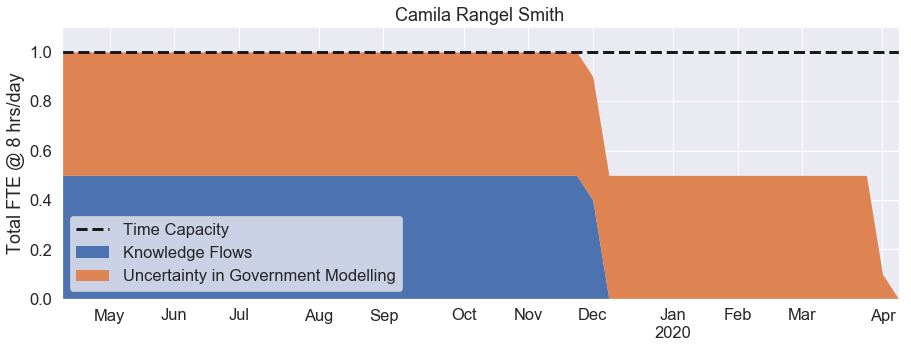

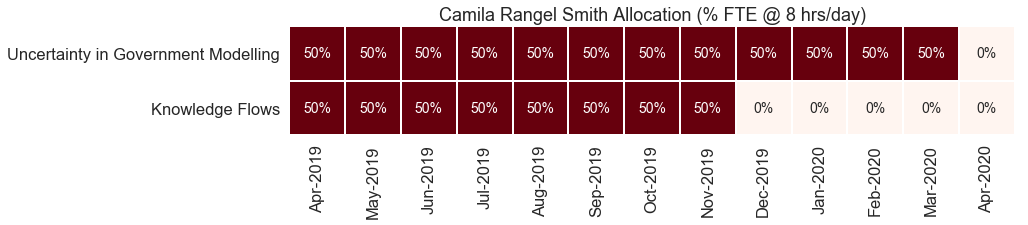

In [11]:
## dropdown list to select a person
widg_person_select = widgets.Dropdown(options=sorted([vis.fc.get_person_name(person_id) for person_id in vis.fc.people.index]),
                                 description='Person:')

def widg_person_select_alloc(change):
    """Function called by widgets to update the person allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_person_select)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    names = widg_person_select.value.split()
    person_id = vis.fc.get_person_id(names[0], ' '.join(names[1:]))
    
    # plot the person allocations
    vis.plot_allocations(person_id, 'person')
    
    # print the person allocations table
    #display(vis.table_allocations(person_id, 'person'))
    vis.heatmap_allocations(person_id, 'person')
    
# setup the event listeners
widg_person_select.observe(widg_person_select_alloc, names='value')

# display the widgets
display(widg_person_select)

# show results with initial values
widg_person_select_alloc(None)

## Show Everyone's Total Project Allocation Over Time

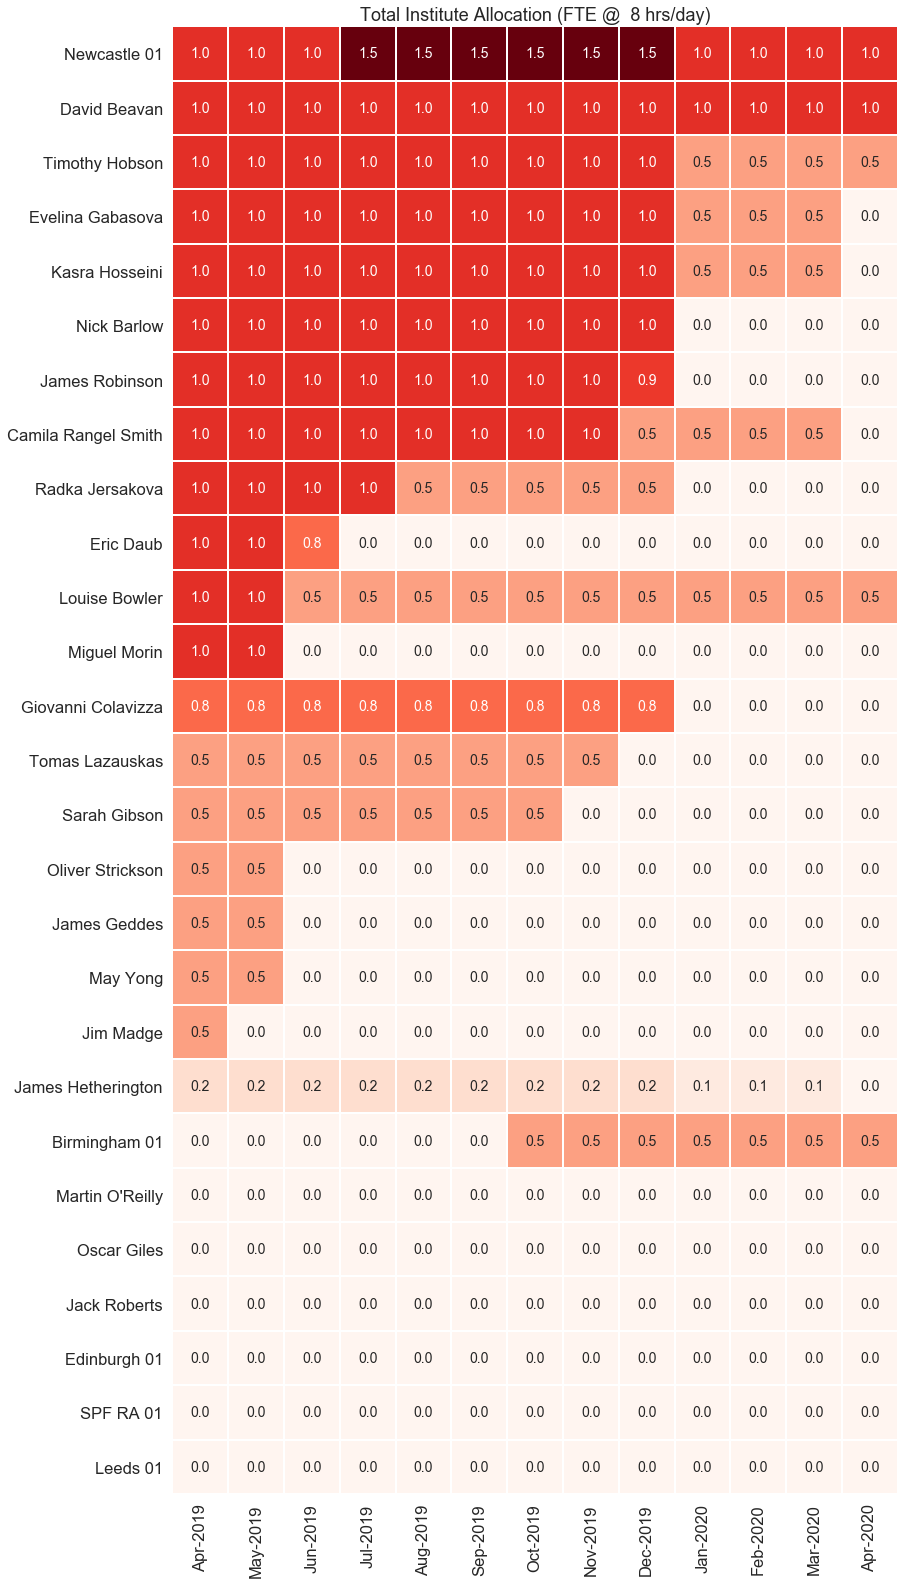

In [12]:
vis.heatmap_allocations('ALL_PEOPLE', 'institute');

## Show Who's Assigned to a Project

In [13]:
## dropdown list to select a project
widg_project_select = widgets.Dropdown(options=sorted([vis.fc.get_project_name(project_id) for project_id in vis.fc.projects.index]),
                                 description='project:')

def widg_project_select_alloc(change):
    """Function called by widgets to update the project allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_project_select)
    
    # get the project_id from the selected full name (need to first split into first and last names)
    project_id = vis.fc.get_project_id(widg_project_select.value)
    
    # plot the project allocations
    vis.plot_allocations(project_id, 'institute')
    
    # plot a heatmap of the allocations
    vis.heatmap_allocations(project_id, 'institute')

# setup the event listeners
widg_project_select.observe(widg_project_select_alloc, names='value')

# display the widgets
display(widg_project_select)

# show results with initial values
widg_project_select_alloc(None)

Dropdown(description='project:', options=('44 days', 'AI assisted diagnosis of children', 'AI for City Plannin…

No institute data to plot for id 1915746 between 2019-04-11 and 2020-04-10
No institute data to plot for id 1915746 between 2019-04-11 and 2020-04-10


## Show the Total Resources Required by All Projects

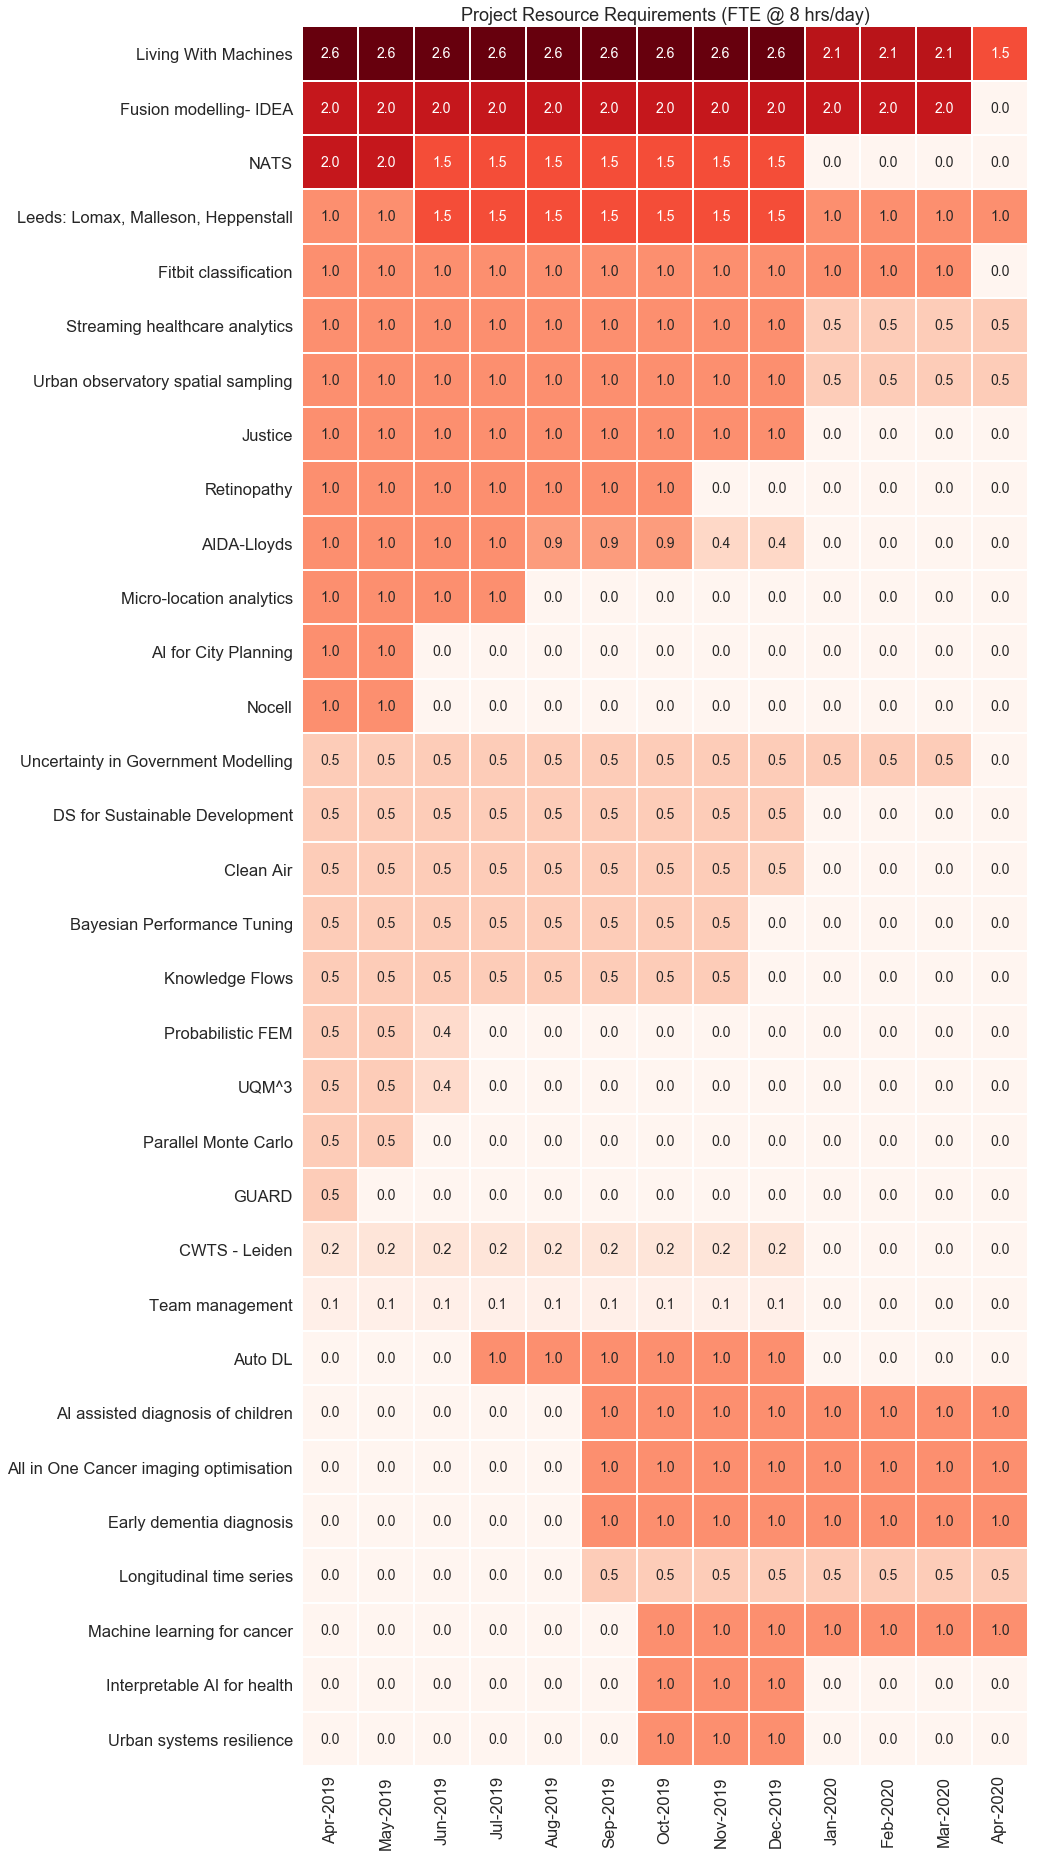

In [14]:
vis.heatmap_allocations('PROJECT_REQUIREMENTS','institute');

## Show the Total Resources Allocated to Each Project

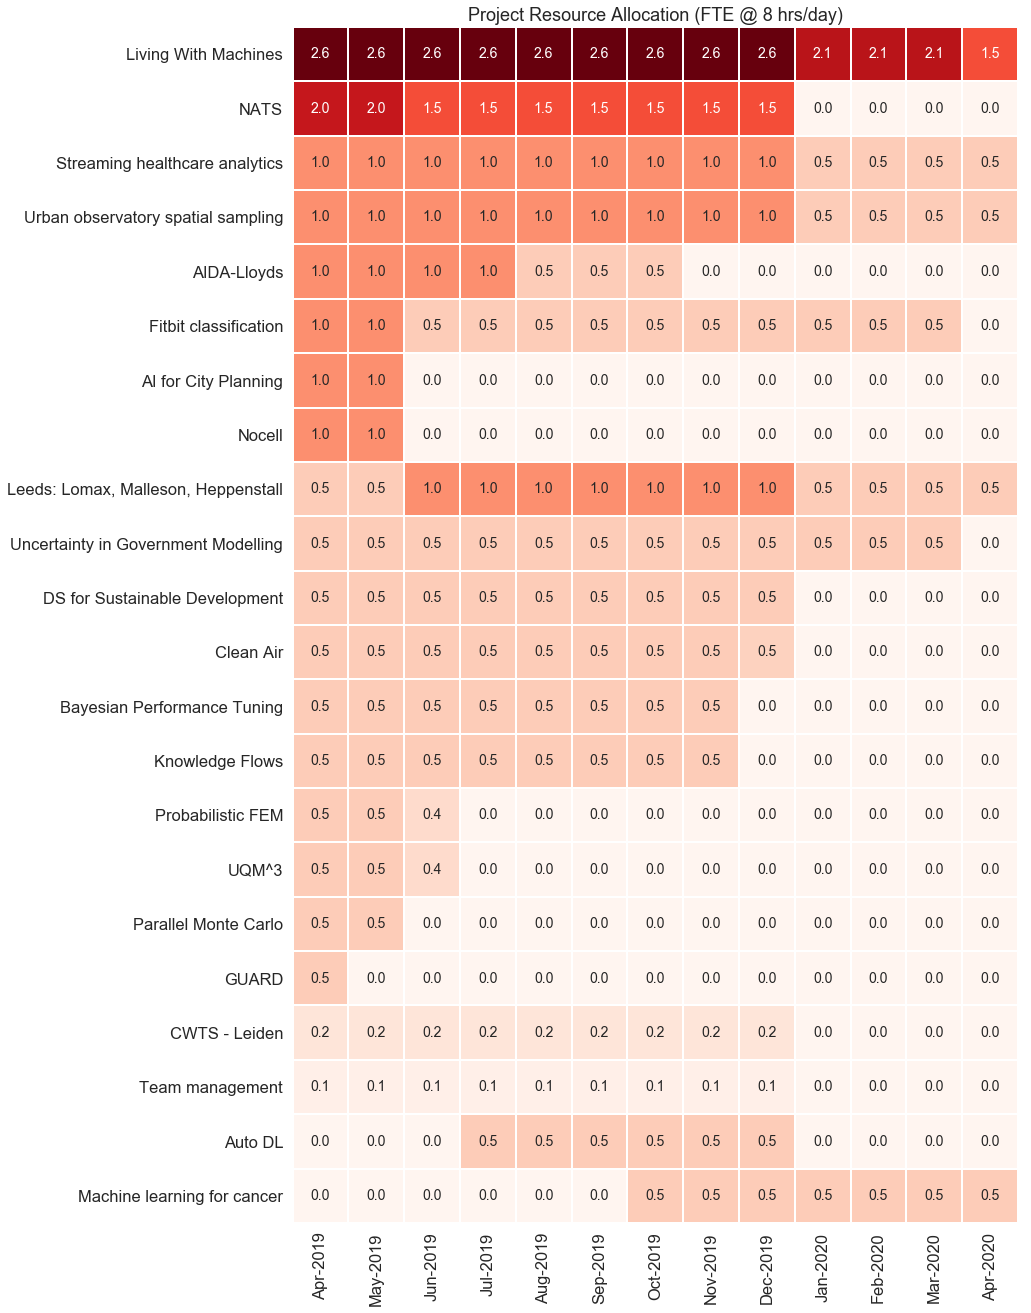

In [15]:
vis.heatmap_allocations('PROJECT_TOTALS', 'institute');

## Show the Additional Resources Needed to be Allocated to Each Project

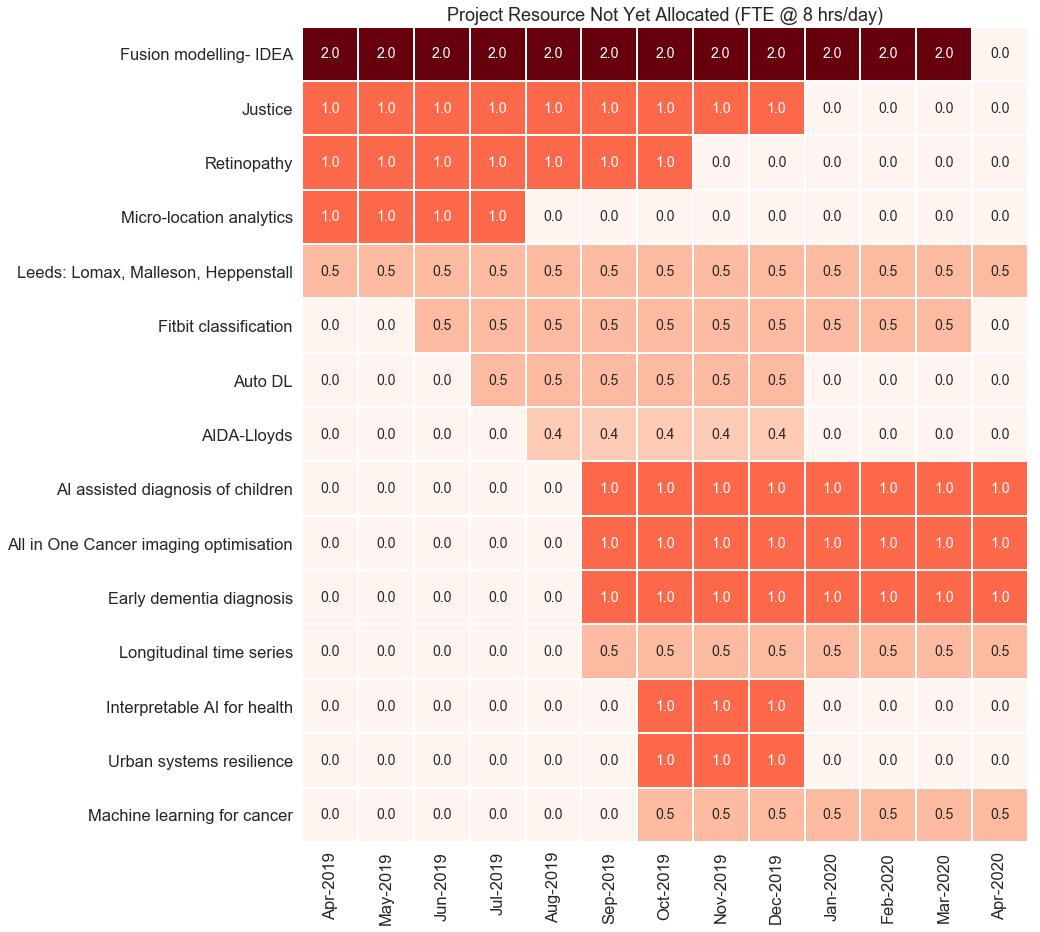

In [16]:
vis.heatmap_allocations('PROJECT_NETALLOC', 'institute');

## Compare the Capcity of the Team to the Requirements of the Projects

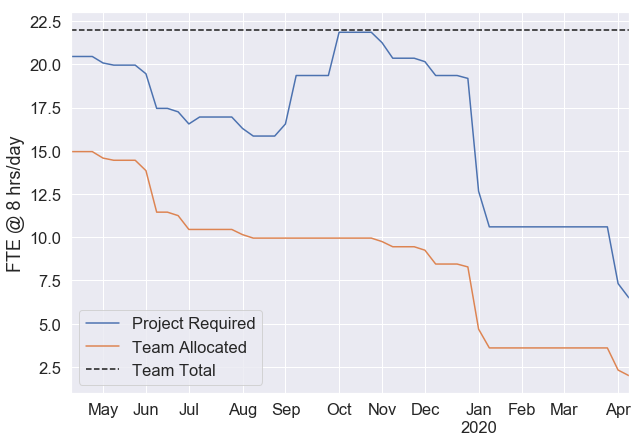

In [17]:
vis.plot_capacity_check();

## Show Allocations for a Placeholder

Dropdown(description='Placeholder:', options=('Birmingham 01', 'Edinburgh 01', 'Leeds 01', 'Newcastle 01', 'Re…

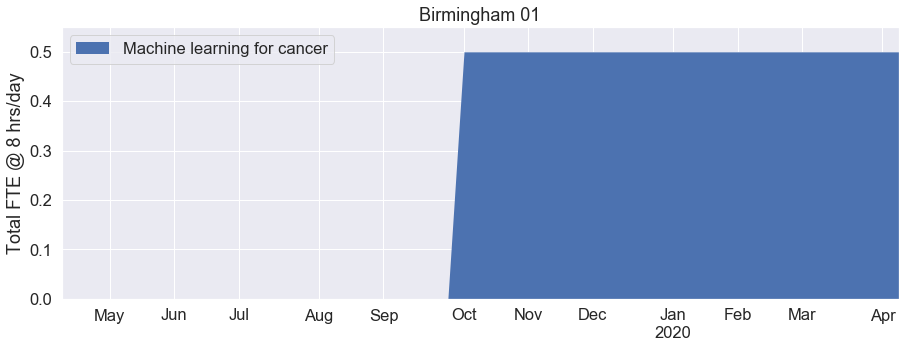

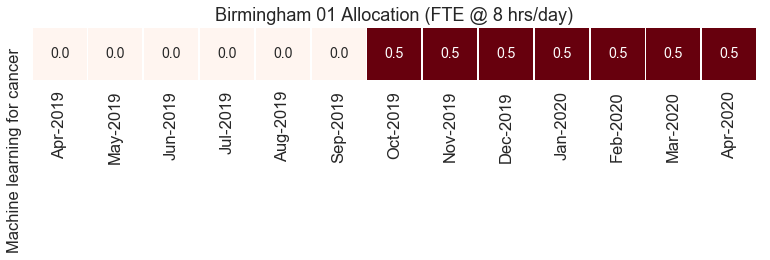

In [18]:
## dropdown list to select a placeholder
widg_place_select = widgets.Dropdown(options=sorted([vis.fc.get_placeholder_name(idx) for idx in vis.fc.placeholders.index]),
                                 description='Placeholder:')

def widg_select_alloc(change):
    """Function called by widgets to update the allocation plot and table.
    The change argument isn't used but it's required for widget.observe."""
    
    # clear the previous output, then display the widgets again
    clear_output()
    display(widg_place_select)
    
    # get the person_id from the selected full name (need to first split into first and last names)
    placeholder_id = vis.fc.get_placeholder_id(widg_place_select.value)
    
    # plot the person allocations
    vis.plot_allocations(placeholder_id, 'placeholder')
    
    # print the person allocations table
    #display(vis.table_allocations(person_id, 'person'))
    vis.heatmap_allocations(placeholder_id, 'placeholder')
    
# setup the event listeners
widg_place_select.observe(widg_select_alloc, names='value')

# display the widgets
display(widg_place_select)

# show results with initial values
widg_select_alloc(None)